In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


plt.style.use('ggplot')
np.__version__

'1.26.4'

In [52]:
!pip install transformers

In [53]:
df = pd.read_csv('/content/Symptom2Disease.csv')
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1200 non-null   int64 
 1   label       1200 non-null   object
 2   text        1200 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.3+ KB


In [55]:
int2label = {}

for i, disease in enumerate(df['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: 'Psoriasis',
  1: 'Varicose Veins',
  2: 'Typhoid',
  3: 'Chicken pox',
  4: 'Impetigo',
  5: 'Dengue',
  6: 'Fungal infection',
  7: 'Common Cold',
  8: 'Pneumonia',
  9: 'Dimorphic Hemorrhoids',
  10: 'Arthritis',
  11: 'Acne',
  12: 'Bronchial Asthma',
  13: 'Hypertension',
  14: 'Migraine',
  15: 'Cervical spondylosis',
  16: 'Jaundice',
  17: 'Malaria',
  18: 'urinary tract infection',
  19: 'allergy',
  20: 'gastroesophageal reflux disease',
  21: 'drug reaction',
  22: 'peptic ulcer disease',
  23: 'diabetes'},
 {'Psoriasis': 0,
  'Varicose Veins': 1,
  'Typhoid': 2,
  'Chicken pox': 3,
  'Impetigo': 4,
  'Dengue': 5,
  'Fungal infection': 6,
  'Common Cold': 7,
  'Pneumonia': 8,
  'Dimorphic Hemorrhoids': 9,
  'Arthritis': 10,
  'Acne': 11,
  'Bronchial Asthma': 12,
  'Hypertension': 13,
  'Migraine': 14,
  'Cervical spondylosis': 15,
  'Jaundice': 16,
  'Malaria': 17,
  'urinary tract infection': 18,
  'allergy': 19,
  'gastroesophageal reflux disease': 20,
  'drug reacti

<ipython-input-56-72bbf9636eac>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(y = df['label'], palette = 'Blues_d')


Text(0.5, 1.0, 'Count of each disease')

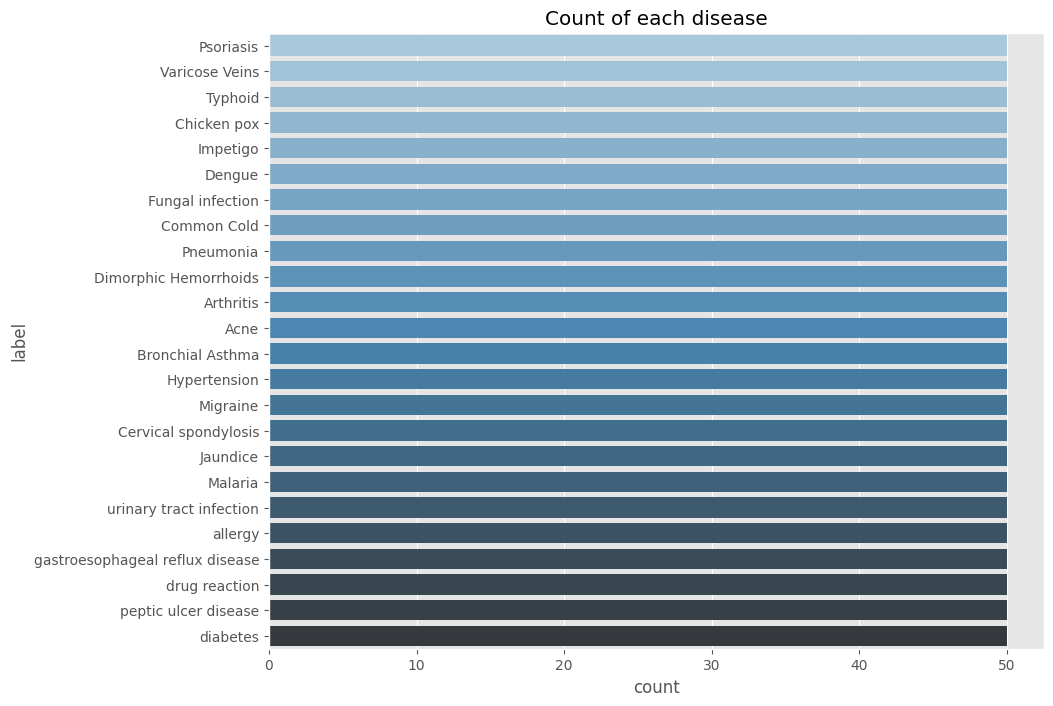

In [56]:
plt.figure(figsize = (10, 8))

sea.countplot(y = df['label'], palette = 'Blues_d')
plt.title('Count of each disease')

  0%|          | 0/1200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of description length')

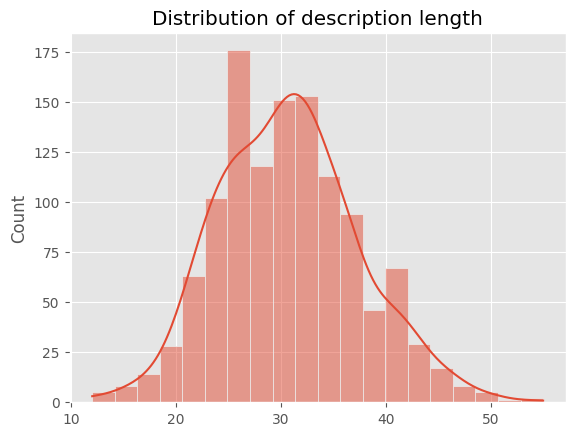

In [57]:
length = []
for txt in tqdm(df['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of description length')

In [58]:
df['label'] = df['label'].map(lambda x : label2int[x])

In [59]:
X, y = df['text'].values, df['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 2414


In [60]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((1080,), (120,), (1080,), (120,))

In [61]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Use BioBERT pretrained model
MODEL_NAME = "dmis-lab/biobert-base-cased-v1.1"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model for sequence classification with PyTorch weights
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,  # Number of classes in your task
    id2label=int2label,
    label2id=label2int,
    output_attentions=True,
    from_pt=True  # Load from PyTorch weights
)

# Compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    metrics=['accuracy']
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
MAX_LENGTH = 512  # Define a fixed maximum length (or any length that fits your data)

train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True, max_length=MAX_LENGTH)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True, max_length=MAX_LENGTH)

BATCH_SIZE = 8  # Set the batch size to a suitable value

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)

In [63]:
EPOCHS = 3

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

Epoch 1/3
135/135 [==============================] - 187s 989ms/step - loss: 2.7407 - accuracy: 0.3241 - val_loss: 1.7291 - val_accuracy: 0.7167
Epoch 2/3
135/135 [==============================] - 130s 960ms/step - loss: 1.1354 - accuracy: 0.8639 - val_loss: 0.6102 - val_accuracy: 0.9000
Epoch 3/3
135/135 [==============================] - 129s 957ms/step - loss: 0.3979 - accuracy: 0.9741 - val_loss: 0.2754 - val_accuracy: 0.9750


In [67]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=num_classes)

# Example predictions
pred1 = pipe("I've had trouble falling asleep because of the rash's pain and itching.")
pred2 = pipe("I have constipation and belly pain, and it's been really uncomfortable.")

print(pred1[0][:3])
print(pred2[0][:3])

Device set to use 0


[{'label': 'Chicken pox', 'score': 0.5617281198501587}, {'label': 'Dengue', 'score': 0.13801799714565277}, {'label': 'Hypertension', 'score': 0.04816678166389465}]
[{'label': 'Typhoid', 'score': 0.826347827911377}, {'label': 'peptic ulcer disease', 'score': 0.04169389232993126}, {'label': 'Chicken pox', 'score': 0.01796342246234417}]


In [68]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print accuracy scores
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}: Training Accuracy = {train_accuracy[epoch]:.4f}, Validation Accuracy = {val_accuracy[epoch]:.4f}")


Epoch 1: Training Accuracy = 0.3241, Validation Accuracy = 0.7167
Epoch 2: Training Accuracy = 0.8639, Validation Accuracy = 0.9000
Epoch 3: Training Accuracy = 0.9741, Validation Accuracy = 0.9750


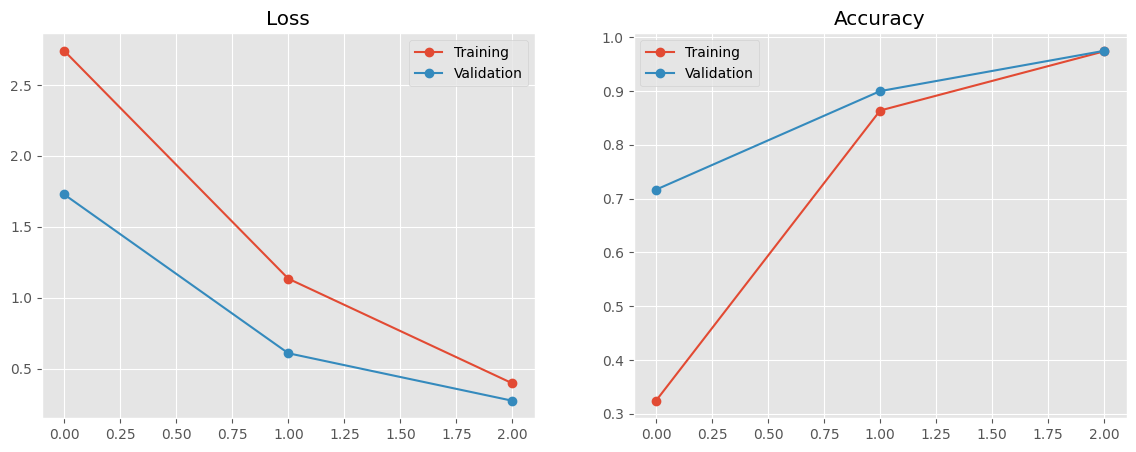

In [69]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], marker='o', label='Training')
plt.plot(history.history['val_loss'], marker='o', label='Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker='o', label='Training')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation')
plt.legend()